<font size="10">Apply *TopicVelo* to scNT-seq (a metabolic labeling method) human haematopoiesis</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import mmwrite 
from scipy.sparse import csr_matrix, hstack

import scvelo as scv
from scvelo.utils import get_transition_matrix

import topicvelo
import sys
parent_path='/Users/frankgao/Documents/topicvelo/'

In [2]:
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [3]:
from topicvelo.tm_utils import cells_to_documents, fast_topics_cluster_assign, topic_genes_filter, remove_u, topic_genes_qc, aggregate_clusters
from topicvelo.embed_pl import plot_topics, plot_top_topic_genes, plot_genes, plot_velocity, mfpt_plot, comparision_stacked_bar_plot, comparision_violin_plot, relative_flux_plot 
from topicvelo.dist_pl import plot_exper_jd, plot_burst_sim_jd, plot_os_analytical_jd, heatmap_exper_cluster_focus_jd
from topicvelo.transcription_simulation import geometric_burst_transcription, joint_distribution_analysis, joint_distribution_analysis_exper
from topicvelo.inference_tools import burst_inference_gene, KL_divergence, topic_threshold_heuristic_plot, burst_inference
from topicvelo.transition_matrix import combined_topics_transitions, get_cells_indices, velocity_graph
from topicvelo.vel_eval_utils import *

<font size="6">read the data which was provided in the *dynamo* paper</font>

In [4]:
#download data at https://uchicago.box.com/s/6ars8qijvt2axbjhxcriu9hybu3gkhkg
adata = scv.read(f'{parent_path}data/scNT-seq/hsc_hv2000.h5ad')
adata.var_names_make_unique
adata.var.index = adata.var['gene_name'].tolist()

<font size="10">Preprocessing</font>
<br>
<font size="6">We create a matrix ```S_U``` by stacking the spliced and unspliced count matrix and save this matrix and the assoicated gene names</font>

In [5]:
genes_S = adata.var['gene_name'].to_list()
genes_U = [g+'_U' for g in genes_S]
gene_names = np.hstack((genes_S, genes_U))

<font size="10">Analysis with scVelo</font>
<br>
<font size="6">We use the stochastic model to compute the velocity and the associated transition matrix.</font>

In [6]:
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity_graph(adata, vkey='scvelo_stochastic_velocity')

computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'scvelo_stochastic_velocity_umap_ori', embedded velocity vectors (adata.obsm)


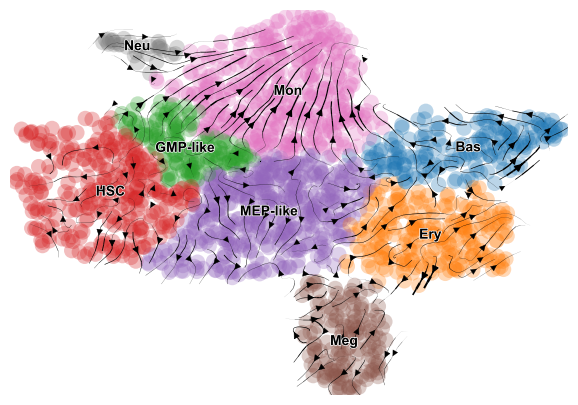

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap_ori',dpi=100, 
                                 color='cell_type', vkey='scvelo_stochastic_velocity', legend_loc='on data', title = '', figsize=(7.2, 5))

<font size="6">From the result above we notice for more than 8 topics, the mean of $C_v$ across 100 reptitions stablizes around 0.4. We do not want to overfit the model so we chose K=8 for further analysis. </font>
<br>
<font size="6">Now we perform topic modeling in *R* using *FastTopics* which can perform advanced differential expression analysis. Please see the *R* markdown file. </font>


<font size="6">After we finished runing the *R* Markodown file, the topic weights and differential expression analysis are saved locally. We load the topic weights of cells and add the topic weights to the adata object. Then we visulize the topic weights on umap.</font>

In [8]:
#load the cellweights from fast topics and skip header and first column which are just junk
cellWeights = np.genfromtxt(f'{parent_path}data/scNT-seq/scNT_HH_fastTopics_fit_CellWeights.csv', delimiter=",", skip_header=1)[:,1:]

In [9]:
#get topic number
K = cellWeights.shape[1]
print(cellWeights.shape)

(1947, 8)


In [10]:
#add topic weights
fast_topics_cluster_assign(adata, cellWeights, t_type = 'fastTopics')

<font size="6">load the differential expression analysis from *FastTopics*. Select topic genes then add them to the adata object for later access</font>

In [11]:
#load the cellweights from fast topics and skip header and first column which are just junk
de_postmean = np.genfromtxt(f'{parent_path}data/scNT-seq/scNT_HH_de_postmean.csv', delimiter=",", skip_header=1)[:,1:]
de_lfsr = np.genfromtxt(f'{parent_path}data/scNT-seq/scNT_HH_de_lfsr.csv', delimiter=",", skip_header=1)[:,1:]
de_z = np.genfromtxt(f'{parent_path}data/scNT-seq/scNT_HH_de_z.csv', delimiter=",", skip_header=1)[:,1:]

In [12]:
#select the topic genes
ttgs, ttg_up, ttg_down = topic_genes_filter(de_postmean, de_lfsr, 
                                            lfc_up_th = 0.5, lfc_down_th=-0.5, 
                                            lfsr_up_th = 0.001, lfsr_down_th = 0.001)

In [13]:
top_genes = remove_u(ttgs, gene_names)
top_genes_up = remove_u(ttg_up, gene_names)
top_genes_down = remove_u(ttg_down, gene_names)

#show how many topic genes have a positive log-fold changes in each topic
for ttgs_up_k in top_genes_up:
    print(len(ttgs_up_k))
print('\n')
for ttgs_k in top_genes:
    print(len(ttgs_k))

78
37
24
92
54
18
30
20


78
43
32
94
57
20
33
26


In [14]:
adata.uns['top_genes'] = top_genes

<font size="10">Choosing topic threshold</font>
<br>
<font size="6">Let's use the heuristics based on the KL divergence of topic genes with the highest log-fold changes</font>

<font size="10">TopicVelo integrates the transition matrices</font>
<br>
<font size="6">We will use previously determined threshold on the topics relevant to differentitaion</font>

In [15]:
#set a random seed to use
np.random.seed(seed=1234)

In [16]:
# topics = [0,1,3,4,7]
# topics_to_use_percentile_thresholds = [35, 35, 35, 35, 35]
topics = [0, 1, 2, 3, 4, 5, 6, 7]
topics_to_use_percentile_thresholds = [35]*8

In [17]:
combined_TM, ttc_indices = combined_topics_transitions(adata, 
                                                       n_workers=8,
                                                       topics = topics, 
                                                       velocity_type = 'burst', 
                                                       recompute_velocity = True,
                                                       recompute_matrix = True, 
                                                       pca_n_comps=15,
                                                       steady_state_perc = 95,
                                                       topic_weights_th_percentile = topics_to_use_percentile_thresholds, 
                                                       subset_save_prefix = f'{parent_path}results/scNT_HH_') 

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 78/78 [00:14<00:00,  5.27it/s]


Time Taken: 15.60 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:02) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 43/43 [00:09<00:00,  4.72it/s]


Time Taken: 10.24 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Time Taken: 8.86 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 94/94 [00:17<00:00,  5.38it/s]


Time Taken: 18.80 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 57/57 [00:11<00:00,  4.93it/s]


Time Taken: 12.84 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Time Taken: 7.37 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 33/33 [00:07<00:00,  4.20it/s]


Time Taken: 9.19 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
Using 8 worker processes


Inferring bursty velocity parameters for genes: 100%|██████████| 26/26 [00:06<00:00,  3.94it/s]


Time Taken: 7.91 seconds
computing velocity graph (using 8/16 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)


Computing the integrated transition matrix: 100%|██████████| 8/8 [00:00<00:00, 89.45it/s]


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_ori', embedded velocity vectors (adata.obsm)


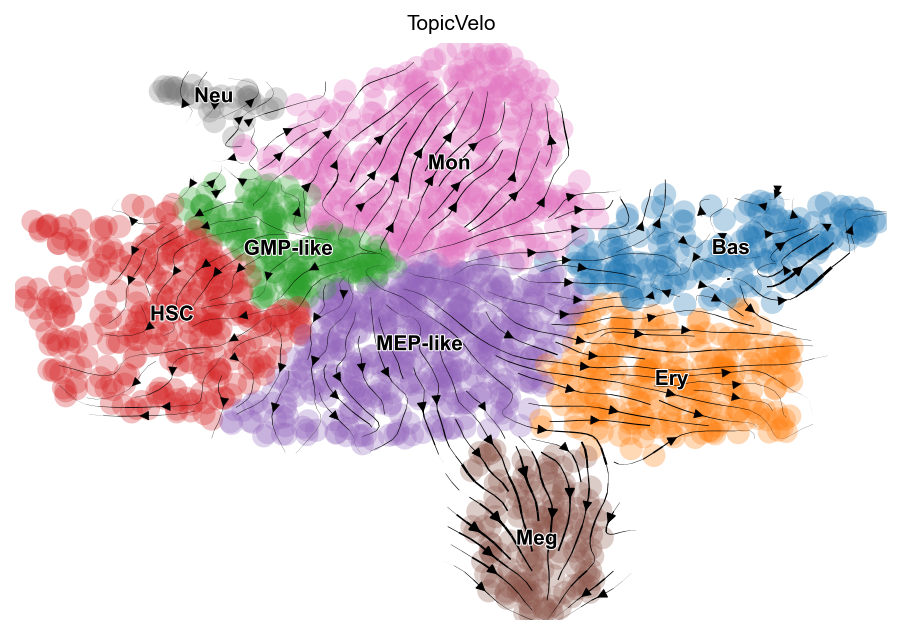

In [18]:
#compute embedded velocity vectors from TopicVelo's integrated transition matrix
topicVelo_embedding = scv.tl.velocity_embedding(adata, basis='umap_ori', T=combined_TM)
scv.pl.velocity_embedding_stream(adata, basis='umap_ori', V=topicVelo_embedding, dpi=150, color='cell_type', legend_loc='on data',
                                 title = 'TopicVelo', figsize=(7.5, 5))

<font size="6">The streamline from *TopicVelo*, as opposed to *scVelo* captures majority of differentiation lineages and agrees much better with *dynamo* (Please see main Figure 3 a, b, c for a side-by-side comparision.</font>

<font size="6">Compute Stationary distribution </font>

In [19]:
adata.obs['topicVelo_stationary_distribution'] = fate_probabilities(adata, 'topicVelo')

In [20]:
adata.obsp['scvelo_stochastic_T'] = get_transition_matrix(adata, vkey='scvelo_stochastic_velocity')
adata.obs['scvelo_stochastic_stationary_distribution'] = fate_probabilities(adata, 'scvelo_stochastic')

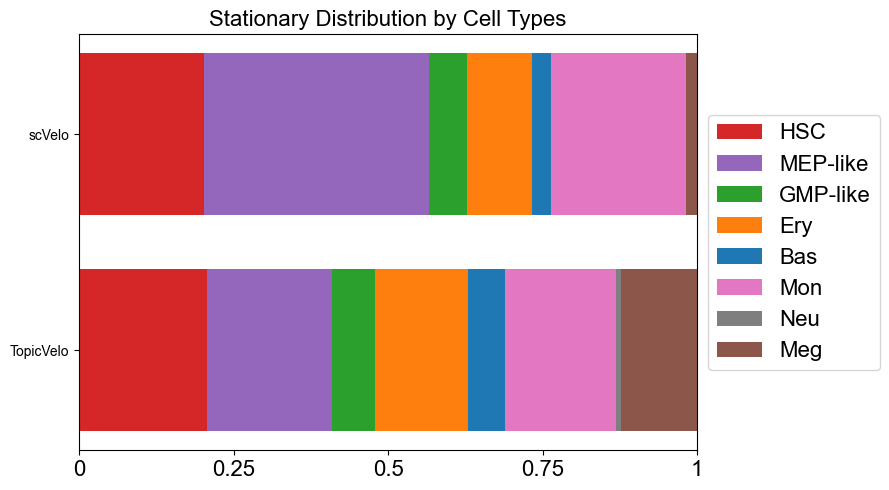

In [21]:
comparision_stacked_bar_plot(adata, ['scvelo_stochastic_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo', 'TopicVelo'], groupby='cell_type',
                             categories=['HSC', 'MEP-like', 'GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                        fontsize=16,  title='Stationary Distribution by Cell Types',
                        figsize=(9,5), savefile='stat_dist.svg')

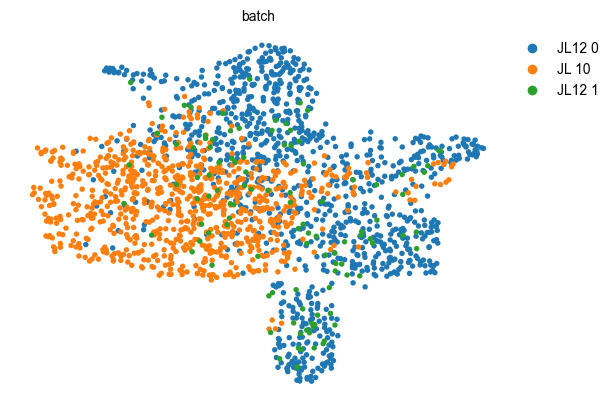

In [22]:
scv.pl.scatter(adata, basis='umap_ori', color='batch')

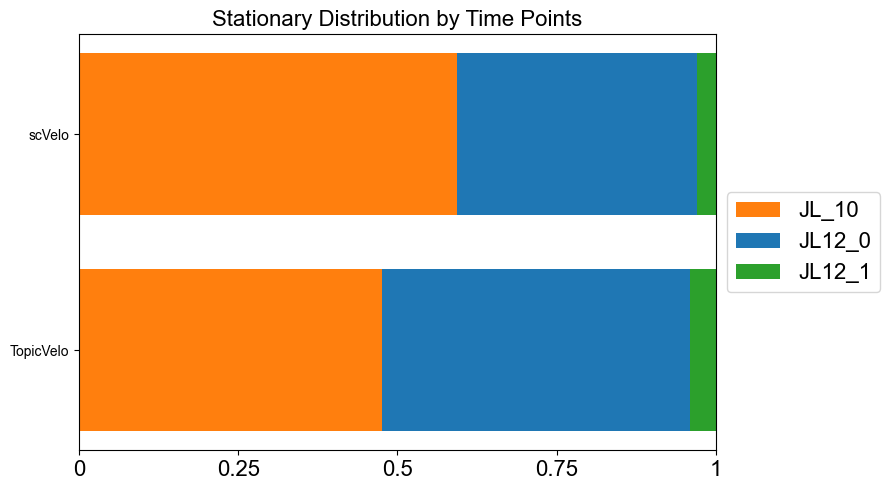

In [23]:
comparision_stacked_bar_plot(adata, ['scvelo_stochastic_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo', 'TopicVelo'], groupby='batch',
                             categories=['JL_10', 'JL12_0', 'JL12_1'],
                        fontsize=16,  title='Stationary Distribution by Time Points',
                        figsize=(9,5), savefile='stat_dist_timepoint.svg')

<font size="6">Compute mean first passage time </font>

In [24]:
#choose destination cells for the mfpt analysis
#cells that have very high meg characteristics were chosen 
dest_cells, _ = get_cells_indices(adata, [3], topic_weights_th_percentile = 95)
dest_cells = np.unique(np.array(dest_cells).flatten())

In [25]:
mfpt_to_targets(adata, 'topicVelo', dest_cells, k_mfpt = 'topicVelo_mfpt_3')
mfpt_to_targets(adata, 'scvelo_stochastic', dest_cells, k_mfpt = 'scVelo_mfpt_3')

barcode
CCACAAGCGTGC-JL12_0    0.969066
CCATCCTGTGGA-JL12_0    0.000000
CCCTCGGCCGCA-JL12_0    0.992642
CCGCCCACCATG-JL12_0    0.969920
CCGCTGTGTAAG-JL12_0    0.961292
                         ...   
GTGAACCTGTGA-JL12_1    1.003056
GTGAGACAATAC-JL12_1    0.987428
GTGATATTGACC-JL12_1    0.669552
GTGCCGCGACAA-JL12_1    0.910084
GTGTGCATTCCT-JL12_1    0.960299
Name: scVelo_mfpt_3, Length: 1947, dtype: float64

In [26]:
#Put other cell types into their own things
aggregate_clusters(adata, 'cell_type', ['HSC', 'MEP-like', 'Ery', 'Meg'], 'cell_type_agg', other_names='others')

In [27]:
adata.obs['cell_type_agg']

barcode
CCACAAGCGTGC-JL12_0      others
CCATCCTGTGGA-JL12_0         Meg
CCCTCGGCCGCA-JL12_0      others
CCGCCCACCATG-JL12_0      others
CCGCTGTGTAAG-JL12_0    MEP-like
                         ...   
GTGAACCTGTGA-JL12_1    MEP-like
GTGAGACAATAC-JL12_1    MEP-like
GTGATATTGACC-JL12_1    MEP-like
GTGCCGCGACAA-JL12_1      others
GTGTGCATTCCT-JL12_1         Ery
Name: cell_type_agg, Length: 1947, dtype: object

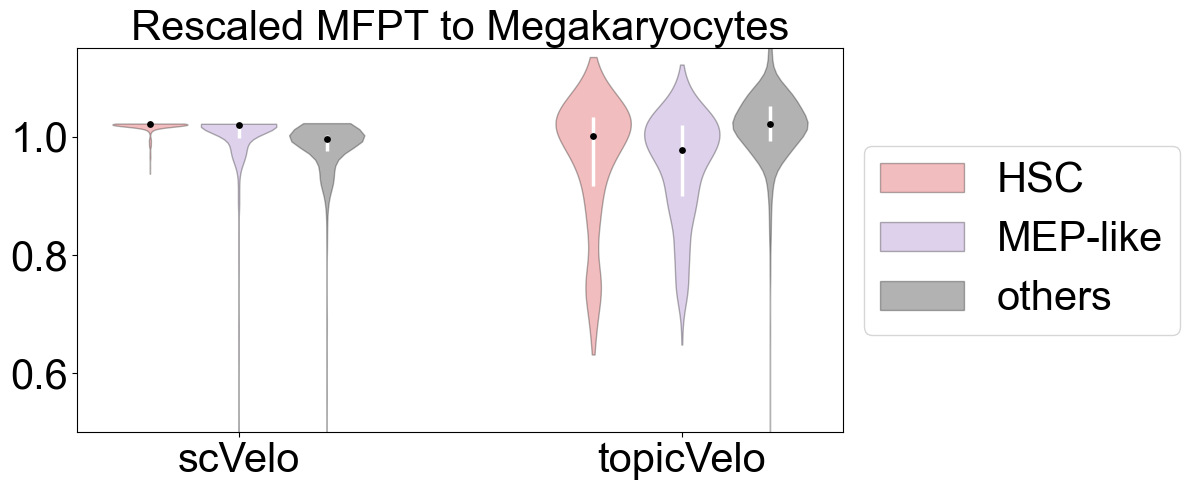

In [28]:
comparision_violin_plot(adata, ['scVelo_mfpt_3', 'topicVelo_mfpt_3'], ['HSC','MEP-like', 'others'],
                           groupby='cell_type_agg', xlabels=['scVelo','topicVelo'],
                           groupby_spacing=5, title='Rescaled MFPT to Megakaryocytes',fontsize=30,
                           figsize=(12,5), ylim=[0.5,1.15], savefile='mfpt_3_main.svg')

<font size="6">Permutation test to get statistical significance between the distribution of mfpt</font>

In [29]:
for k_mfpt in ['scVelo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'HSC', permutation_test(adata, 'cell_type_agg', 'HSC', 'others', k_mfpt, alternative='less'))

scVelo_mfpt_3 HSC 1.0
topicVelo_mfpt_3 HSC 0.0001


In [30]:
for k_mfpt in ['scVelo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'MEP-like', permutation_test(adata, 'cell_type_agg', 'MEP-like', 'others', k_mfpt, alternative='less'))

scVelo_mfpt_3 MEP-like 1.0
topicVelo_mfpt_3 MEP-like 0.0001


<font size="6">Compute relative flux between known transitions </font>

In [31]:
cluster_transitions = [('GMP-like','Mon'),('GMP-like','Bas'),
                       ('MEP-like','Ery'), ('MEP-like','Meg')]
transition_matrices = [ 'scvelo_stochastic_T', 'topicVelo_T']

In [32]:
res = []
for k_transition_matrix in transition_matrices:
    res.append((k_transition_matrix, 
                relative_flux_correctness(adata,'cell_type', k_transition_matrix, cluster_transitions)[0]))

In [33]:
res

[('scvelo_stochastic_T',
  {('GMP-like', 'Mon'): 0.02974682575973119,
   ('GMP-like', 'Bas'): -0.15163620364637181,
   ('MEP-like', 'Ery'): 0.357537601683129,
   ('MEP-like', 'Meg'): 0.0077515491028809546}),
 ('topicVelo_T',
  {('GMP-like', 'Mon'): 0.06459385349327329,
   ('GMP-like', 'Bas'): -0.08642687827442337,
   ('MEP-like', 'Ery'): 0.313694014841862,
   ('MEP-like', 'Meg'): 0.31583590144533924})]

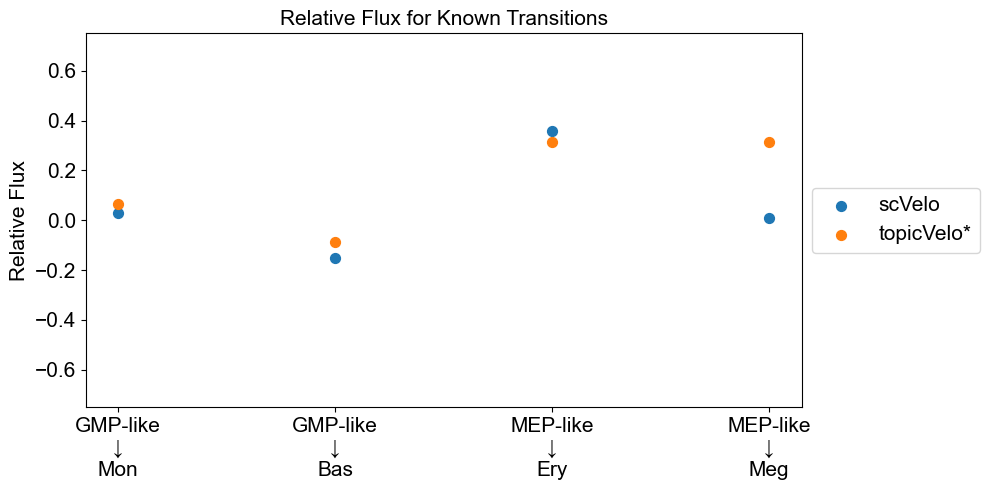

In [34]:
relative_flux_plot(adata,['scvelo_stochastic_T','topicVelo_T'], 
                   legends = ['scVelo', 'topicVelo*'],
                   title = 'Relative Flux for Known Transitions', ylim=[-0.75, 0.75], figsize=(10,5), fontsize=15)